In [46]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, transform

In [47]:
TIMESTEPS = 100  # Numero di passi (T)
IMG_SIZE = 64    # Dimensione immagine

In [48]:

# 1. Definizione dello Scheduler (Linear Noise Schedule)
# Questi sono i coefficienti fissi che decidono quanto rumore aggiungere
betas = torch.linspace(0.0001, 0.02, TIMESTEPS)
alphas = 1.0 - betas
alphas_cumprod = torch.cumprod(alphas, dim=0) # alpha_bar
alphas_cumprod_prev = torch.cat([torch.tensor([1.0]), alphas_cumprod[:-1]]) # alpha_bar_{t-1}

# Funzione helper per estrarre i valori al tempo t
def get_val(tensor, t, x_shape):
    batch_size = t.shape[0]
    out = tensor.gather(-1, t)
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1)))


In [49]:
alphas_cumprod.shape, alphas_cumprod_prev.shape

(torch.Size([100]), torch.Size([100]))

In [50]:
def get_val(tensor, t, x_shape):
    batch_size = t.shape[0]
    out = tensor.gather(-1, t)
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1)))

class OracleModel:
    def __init__(self, original_x0):
        self.x0 = original_x0
    
    def predict_noise(self, x_t, t):
        # Invece di una U-Net che indovina, usiamo l'algebra inversa per trovare il rumore esatto.
        # Sappiamo che: x_t = sqrt(alpha_bar) * x0 + sqrt(1 - alpha_bar) * epsilon
        # Quindi: epsilon = (x_t - sqrt(alpha_bar) * x0) / sqrt(1 - alpha_bar)
        
        sqrt_alpha_cumprod = get_val(torch.sqrt(alphas_cumprod), t, x_t.shape)
        sqrt_one_minus_alpha_cumprod = get_val(torch.sqrt(1 - alphas_cumprod), t, x_t.shape)
        
        # Calcolo analitico del rumore (simula una rete neurale perfetta)
        noise = (x_t - sqrt_alpha_cumprod * self.x0) / sqrt_one_minus_alpha_cumprod
        return noise

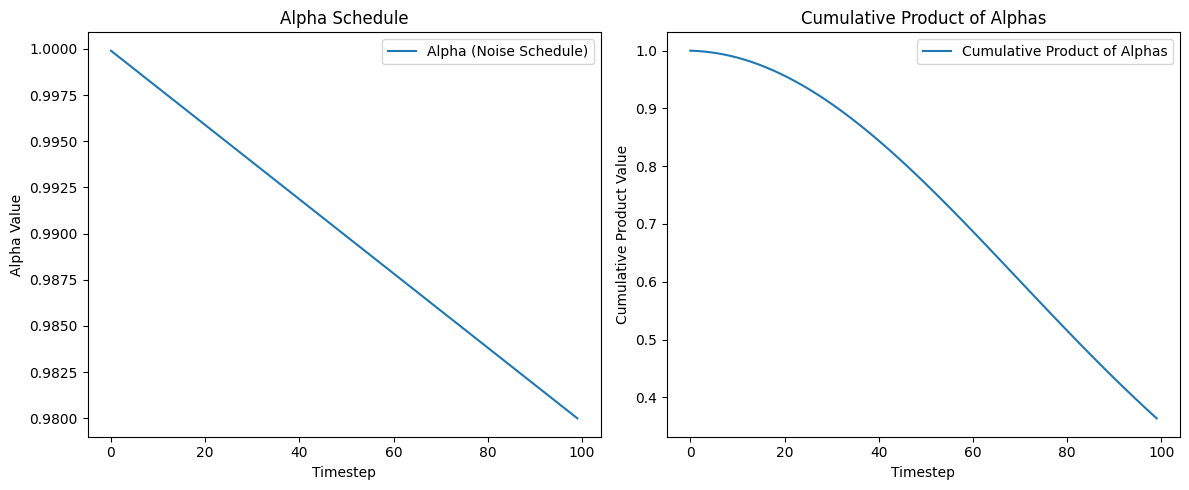

In [51]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(alphas.numpy(), label='Alpha (Noise Schedule)')
ax[0].set_title('Alpha Schedule')
ax[0].set_xlabel('Timestep')
ax[0].set_ylabel('Alpha Value')
ax[0].legend()
ax[1].plot(alphas_cumprod.numpy(), label='Cumulative Product of Alphas')
ax[1].set_title('Cumulative Product of Alphas')
ax[1].set_xlabel('Timestep')
ax[1].set_ylabel('Cumulative Product Value')
ax[1].legend()
plt.tight_layout()
plt.show()

(np.float64(-0.5), np.float64(63.5), np.float64(63.5), np.float64(-0.5))

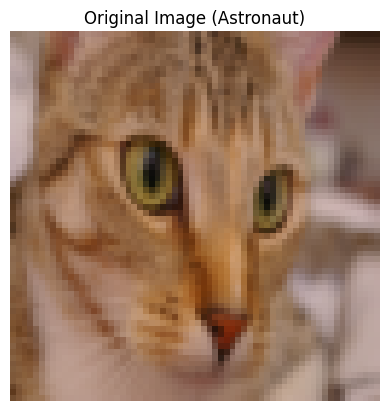

In [52]:
# immagine di un cerchio 
original_image = data.chelsea()
original_image = transform.resize(original_image, (IMG_SIZE, IMG_SIZE), anti_aliasing=True)
original_image = torch.from_numpy(original_image).float().unsqueeze(0)  # Shape: (1, 1, H, W)
    
plt.imshow(original_image.squeeze().numpy(), cmap='gray')
plt.title('Original Image (Astronaut)')
plt.axis('off')

In [53]:
# --- A. DDPM Sampling (Classico, Stocastico) ---
# Equazione con termine random sigma_t * z
@torch.no_grad()
def sample_ddpm(model, x_t):
    imgs = [x_t.clone()]
    for i in reversed(range(TIMESTEPS)):
        t = torch.tensor([i])
        z = torch.randn_like(x_t) if i > 0 else 0  # Rumore casuale (Stocasticità!)
        
        # 1. Predici il rumore
        eps_theta = model.predict_noise(x_t, t)
        
        # 2. Coefficienti DDPM
        alpha = get_val(alphas, t, x_t.shape)
        alpha_bar = get_val(alphas_cumprod, t, x_t.shape)
        sigma = get_val(torch.sqrt(betas), t, x_t.shape) # Sigma standard
        
        # 3. Passo indietro (Eq. DDPM Classico)
        # x_{t-1} = 1/sqrt(alpha) * (x_t - coeff * eps) + sigma * z
        coeff = (1 - alpha) / torch.sqrt(1 - alpha_bar)
        x_t = (1 / torch.sqrt(alpha)) * (x_t - coeff * eps_theta) + sigma * z
        
    return x_t

# --- B. DDIM Sampling (Deterministico, sigma=0) ---
# Usa l'Eq. 7 del paper con sigma=0
@torch.no_grad()
def sample_ddim(model, x_t):
    for i in reversed(range(TIMESTEPS)):
        t = torch.tensor([i])
        
        # 1. Predici il rumore
        eps_theta = model.predict_noise(x_t, t)
        
        # 2. Parametri per passo t e t-1
        alpha_bar = get_val(alphas_cumprod, t, x_t.shape)
        alpha_bar_prev = get_val(alphas_cumprod_prev, t, x_t.shape)
        
        # 3. Predici x0 "pulito" (f_theta)
        pred_x0 = (x_t - torch.sqrt(1 - alpha_bar) * eps_theta) / torch.sqrt(alpha_bar)
        
        # 4. Direzione verso x_t (senza rumore casuale aggiuntivo!)
        dir_xt = torch.sqrt(1 - alpha_bar_prev) * eps_theta
        
        # 5. Passo Deterministico (Eq. 7 con sigma=0)
        x_t = torch.sqrt(alpha_bar_prev) * pred_x0 + dir_xt
        
    return x_t

# --- C. DDIM Inversion (Encoding) ---
# Usa l'Eq. 8 del paper (t -> t+1)
@torch.no_grad()
def invert_ddim(model, x_0):
    x_t = x_0.clone()
    for i in range(TIMESTEPS):
        t = torch.tensor([i])
        t_next = torch.tensor([i + 1]) if i < TIMESTEPS - 1 else t # Gestione ultimo step
        
        # 1. Predici il rumore (qui il modello usa x_t corrente)
        eps_theta = model.predict_noise(x_t, t)
        
        # 2. Parametri attuali (t) e futuri (t+1)
        alpha_bar = get_val(alphas_cumprod, t, x_t.shape)
        alpha_bar_next = get_val(alphas_cumprod, t_next, x_t.shape)
        
        if i == TIMESTEPS - 1: # Ultimo step, non andiamo oltre
            break

        # 3. Predici x0 (f_theta)
        # Nota: anche se partiamo da x0 vero, usiamo la formula inversa per coerenza matematica
        pred_x0 = (x_t - torch.sqrt(1 - alpha_bar) * eps_theta) / torch.sqrt(alpha_bar)
        
        # 4. Passo in avanti Deterministico (Eq. 8)
        # x_{t+1} = sqrt(alpha_bar_next) * f_theta + sqrt(1 - alpha_bar_next) * eps_theta
        x_t = torch.sqrt(alpha_bar_next) * pred_x0 + torch.sqrt(1 - alpha_bar_next) * eps_theta
        
    return x_t

Ricostruzione DDPM in corso...
Inversione DDIM (Encoding) in corso...
Ricostruzione DDIM (Decoding) in corso...


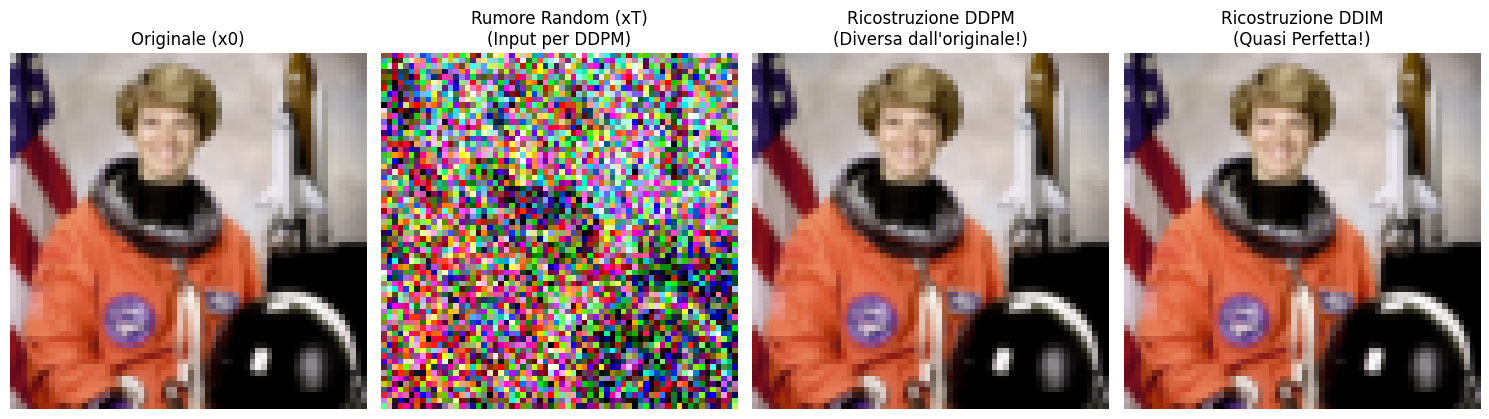

In [54]:
# 1. Prepara l'immagine
img = data.astronaut()
img = transform.resize(img, (IMG_SIZE, IMG_SIZE))
x0 = torch.from_numpy(img).permute(2, 0, 1).float().unsqueeze(0) # (1, 3, 64, 64)
# Normalizza tra -1 e 1 (standard per DDPM)
x0 = (x0 * 2) - 1 

# 2. Inizializza il modello oracolo
model = OracleModel(x0)

# --- ESPERIMENTO 1: DDPM (Stocastico) ---
# Nel DDPM non esiste l'inversione esatta. Simuliamo prendendo il rumore finale 
# di un processo forward randomico.
# Forward process manuale (aggiunta rumore casuale)
noise = torch.randn_like(x0)
x_T_random = torch.sqrt(alphas_cumprod[-1]) * x0 + torch.sqrt(1 - alphas_cumprod[-1]) * noise

print("Ricostruzione DDPM in corso...")
rec_ddpm = sample_ddpm(model, x_T_random)


# --- ESPERIMENTO 2: DDIM (Deterministico / Autoencoder) ---
# Qui facciamo il ciclo completo: Immagine -> Latente -> Immagine
print("Inversione DDIM (Encoding) in corso...")
z_T_deterministic = invert_ddim(model, x0) # Eq. 8

print("Ricostruzione DDIM (Decoding) in corso...")
rec_ddim = sample_ddim(model, z_T_deterministic) # Eq. 7 (sigma=0)


# --- Visualizzazione ---
def show(tensor, title):
    # Denormalizza
    img = (tensor.squeeze().permute(1, 2, 0).numpy() + 1) / 2
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')

plt.figure(figsize=(15, 5))

plt.subplot(1, 4, 1)
show(x0, "Originale (x0)")

plt.subplot(1, 4, 2)
show(x_T_random, "Rumore Random (xT)\n(Input per DDPM)")

plt.subplot(1, 4, 3)
show(rec_ddpm, "Ricostruzione DDPM\n(Diversa dall'originale!)")

plt.subplot(1, 4, 4)
show(rec_ddim, "Ricostruzione DDIM\n(Quasi Perfetta!)")

plt.tight_layout()
plt.show()